In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import os
import pathlib
import urllib.request
import tarfile
import pandas as pd

In [2]:
# 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format

In [3]:
download_dir = pathlib.Path(os.getcwd(), '../food')  # pathlib를 사용해서 경로 처리
download_dir.mkdir(parents=True, exist_ok=True)  # 디렉토리 생성
data_dir = download_dir

# training 데이터 디렉토리
training_dir = download_dir / "training"  # pathlib를 사용한 경로 결합

# 클래스 목록 가져오기
classes = sorted([item.name for item in training_dir.glob('*/') if item.is_dir()])
image_count = len(list(training_dir.glob('*/*.jpg')))  # jpg 파일 개수 세기

# 결과 출력
print(f"발견된 클래스 : {classes}")
print(f"총 이미지 개수 : {image_count}")

발견된 클래스 : ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']
총 이미지 개수 : 9866


In [4]:
for class_name in classes:
    class_images = len(list(training_dir.glob(f'{class_name}/*')))
    print(f"{class_name} : {class_images}개 이미지")

Bread : 994개 이미지
Dairy product : 429개 이미지
Dessert : 1500개 이미지
Egg : 986개 이미지
Fried food : 848개 이미지
Meat : 1325개 이미지
Noodles-Pasta : 440개 이미지
Rice : 280개 이미지
Seafood : 855개 이미지
Soup : 1500개 이미지
Vegetable-Fruit : 709개 이미지


In [5]:
# 이미지 크기 및 배치 크기 설정
img_height = 180
img_width = 180
batch_size = 32

In [6]:
# 훈련 데이터셋 생성
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_dir / "training"),
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 9866 files belonging to 11 classes.
Using 7893 files for training.


In [7]:
# 검증 데이터셋 생성
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_dir / "validation"),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3430 files belonging to 11 classes.
Using 686 files for validation.


In [8]:
# 클래스 이름 확인
class_names = train_ds.class_names
print("클래스 : ", class_names)
num_classes = len(class_names)

클래스 :  ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


In [9]:
# 데이터셋 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [10]:
# 데이터 증강 레이어 정의
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

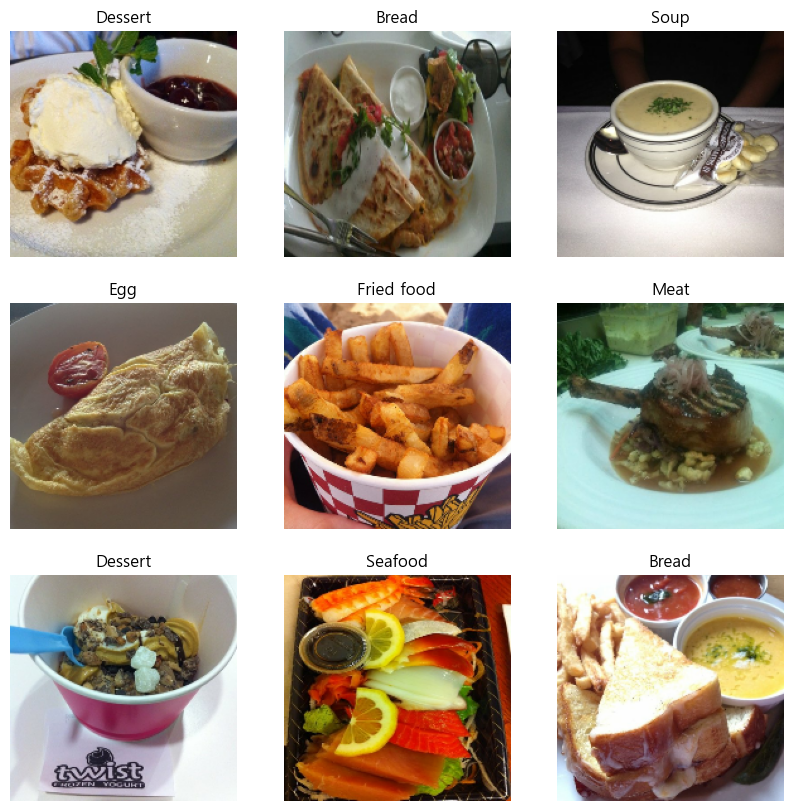

In [11]:
# 샘플 이미지 시각화
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [12]:
# CNN 모델 구성
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

c:\aiproject2\.venv\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# 모델 컴파일
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [14]:
# 모델 구조 출력
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Early Stopping 콜백 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 3,
        restore_best_weights = True
    )
]

In [16]:
# 모델 학습
epochs = 30
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    callbacks = callbacks
)

Epoch 1/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 51s 198ms/step - accuracy: 0.1901 - loss: 2.2487 - val_accuracy: 0.3090 - val_loss: 2.0337
Epoch 2/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 51s 206ms/step - accuracy: 0.3149 - loss: 1.9302 - val_accuracy: 0.3673 - val_loss: 1.8465
Epoch 3/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 51s 208ms/step - accuracy: 0.3542 - loss: 1.8305 - val_accuracy: 0.3601 - val_loss: 1.8268
Epoch 4/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 55s 221ms/step - accuracy: 0.3869 - loss: 1.7552 - val_accuracy: 0.3921 - val_loss: 1.7849
Epoch 5/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 57s 230ms/step - accuracy: 0.4176 - loss: 1.6752 - val_accuracy: 0.3950 - val_loss: 1.7254
Epoch 6/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 56s 225ms/step - accuracy: 0.4215 - loss: 1.6394 - val_accuracy: 0.4592 - val_loss: 1.5844
Epoch 7/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 63s 255ms/step - accuracy: 0.4551 - loss: 1.5741 - val_accuracy: 0.4402 - val_loss: 1.6402
Epoch 8/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 53s 216ms/step - accuracy: 0.4726 - loss: 1

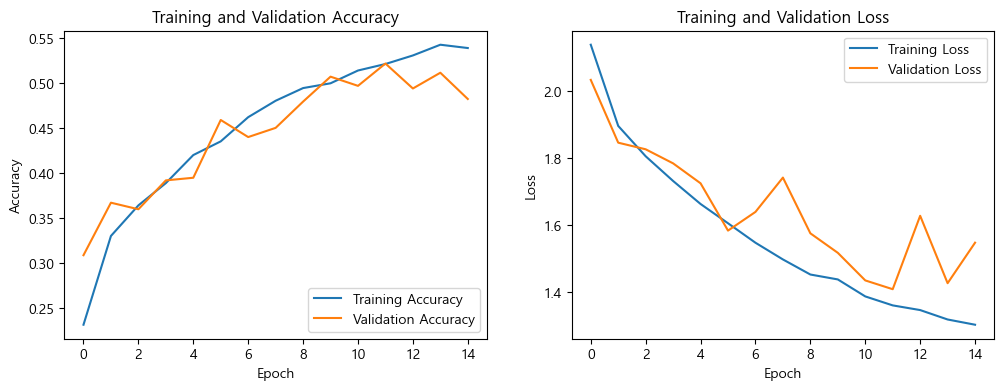

In [17]:
# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [18]:
#  모델 저장
model.save('../model/food_classification_model.h5')
print("모델이 'food_classification_model.h5'로 저장되었습니다.")

모델이 'food_classification_model.h5'로 저장되었습니다.


In [19]:
# 저장된 모델 불러오기
from tensorflow.keras.models import load_model

In [20]:
model_path = '../model/food_classification_model.h5'   # 저장된 모델 경로
loaded_model = load_model(model_path)
print("저장된 모델이 성공적으로 로드되었습니다.")

저장된 모델이 성공적으로 로드되었습니다.


In [21]:
# 저장된 모델을 활용한 이미지 예측 함수
def predict_flower_with_loaded_model(img_path, model, class_names):
    """
    이미지 경로와 모델을 입력박아 예측 결과를 출력하고 이미지를 시각화하는 함수
    
    Parameters:
        img_path(str) : 예측할 이미지 경로
        model(tf.keras.Model) : 저장된 모델
        class_names(list) : 클래스 이름 리스트
    """
    

    # 이미지 로드 및 전처리
    img = tf.keras.preprocessing.image.load_img(
        img_path, target_size = (img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)    # 배치 자원 추가

    # 예측 수행
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    # 예측 결과 출력
    print(
        "이 이미지는 '{}' ({:.2f}% 확률) 입니다."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

    # 이미지 시각화
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [22]:
test_image_path = '../food/training/Bread/0.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
이 이미지는 'Bread' (13.89% 확률) 입니다.


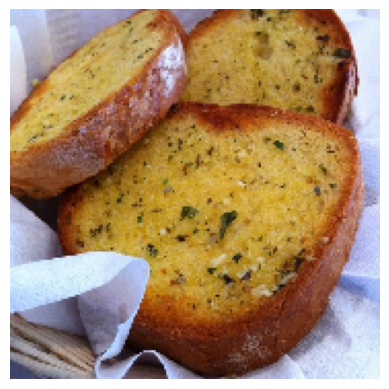

In [23]:
# 예측 실행
predict_flower_with_loaded_model(test_image_path, loaded_model, class_names)